# Intro to Logistic Regression

We will discuss
   * classification problems
   * how to use logistical regression to solve them
   * how to interpret the results of a logistic regression through a confusion matrix

In [1]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import seaborn as sns;
%matplotlib inline

In [2]:
train = pd.read_csv('titanic_train.csv');

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


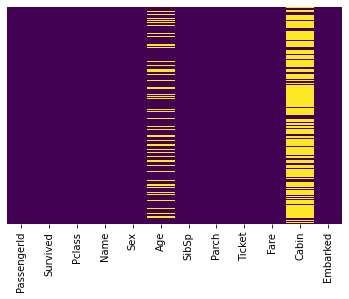

In [7]:
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'viridis');

In [8]:
# we can probably impute the age column since we have enough data to fill in the gaps

In [9]:
# we can't say the same for the cabin data though; we may end up dropping it :(

In [10]:
sns.set_style('whitegrid');

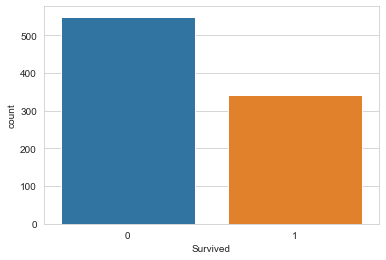

In [11]:
# to see who survived and who didn't
sns.countplot(x = 'Survived', data = train);

<AxesSubplot:xlabel='Survived', ylabel='count'>

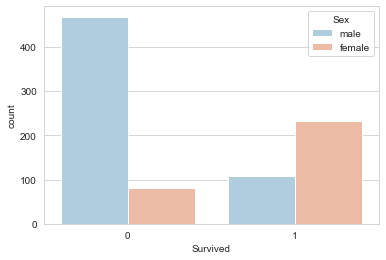

In [14]:
sns.countplot(x = 'Survived', data = train, hue = 'Sex', palette = 'RdBu_r')

Inference: Fewer men survived as compared to women. Almost twice the amount of women survived than men

<AxesSubplot:xlabel='Survived', ylabel='count'>

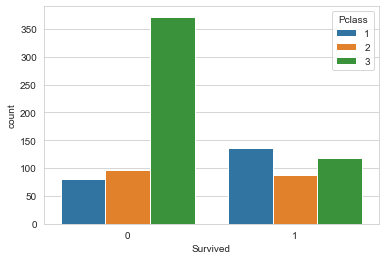

In [16]:
# looking at the passenger class (Pclass) now
sns.countplot(x = 'Survived', data = train, hue = 'Pclass')

Inference: More 3rd class passengers died than other ones. 3rd class passengers were the cheapest seats available so they are highly likely to be from the lower classes. The 1st class passengers were the most likely to survive.

<AxesSubplot:xlabel='Age', ylabel='Count'>

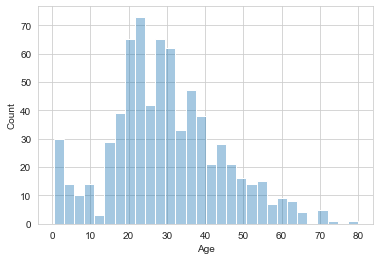

In [20]:
sns.histplot(train['Age'].dropna(), bins = 30, alpha = 0.4)

Inference: It's  bimodal distribution. A lot of young passengers. A slight skew towards the 30s age group later. The older you were, the less representation you had on board.

<AxesSubplot:ylabel='Frequency'>

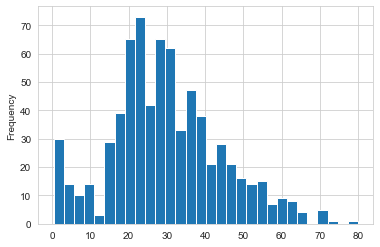

In [21]:
# Alt. way to visualize this using pandas library
train['Age'].plot.hist(bins = 30)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<AxesSubplot:xlabel='SibSp', ylabel='count'>

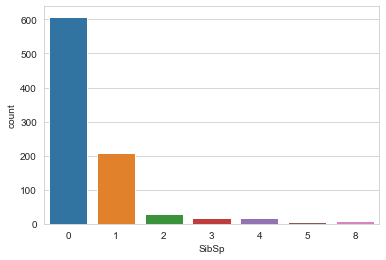

In [23]:
sns.countplot(x= 'SibSp', data = train)

Inference: Most people on board didn't have wither a sibling or a spouse with them on board. Most of who did, had only 1 person with them (likely their spouse since this is the 19th century we're talking about; single parents travelling with their kids was kind of a rarity back then)

In [24]:
train['Fare']

0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 891, dtype: float64

<AxesSubplot:>

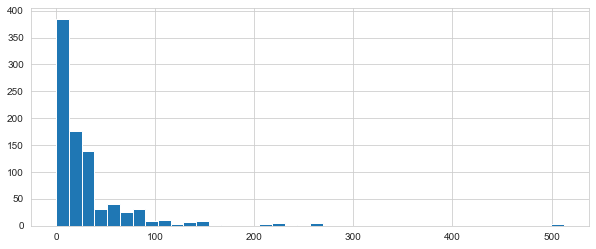

In [26]:
train['Fare'].hist(bins = 40, figsize =(10, 4))

Inference: Most of the purchase prices were between 0-50. Most passengers were in the cheaper, 3rd class (prices not adjusted for inflation!)

In [28]:
# we can alt. do this with cufflinks
import cufflinks as cf;
cf.go_offline();
train['Fare'].iplot(kind = 'hist', bins = 50)

### I am now going to impute the data to fill in the missing values

We could just fill in the missing age values with the mean age values BUT...

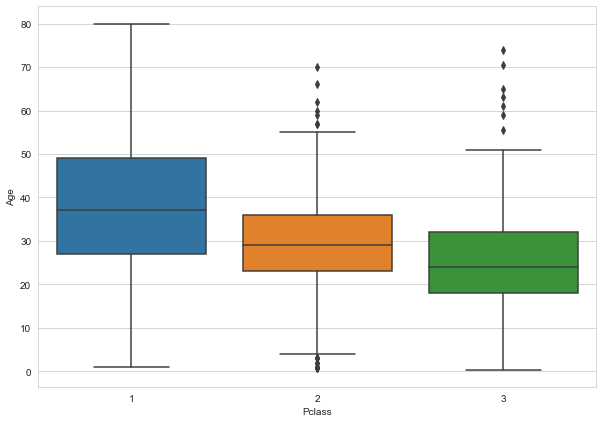

In [31]:
plt.figure(figsize = (10, 7));
sns.boxplot(x = 'Pclass', y = 'Age', data = train);

Inference: The wealthier passengers are likely to be older than the other classes.

In [35]:
#train.iplot(kind = 'box', x = 'Pclass', y = 'Age');

In [37]:
# to fill in the missing vals
def impute_age (cols):
    Age = cols[0];
    Pclass = cols[1];
    if (pd.isnull(Age)):
        if (Pclass == 1):
            return 37;
        elif(Pclass == 2):
            return 29;
        else:
            return 24;
    else:
        return Age;

In [41]:
train[['Age', 'Pclass']].apply(impute_age, axis = 1).isnull().sum()

0

In [42]:
train ['Age'] = train[['Age', 'Pclass']].apply(impute_age, axis = 1);

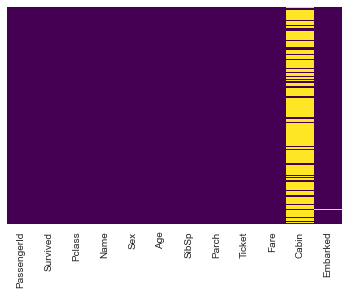

In [43]:
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'viridis');

We imputed the age data!!!! YESSSSS

There's too much missing data in the Cabin column, so I'm just going to drop it

In [44]:
train.drop('Cabin', axis = 1, inplace = True)

In [45]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


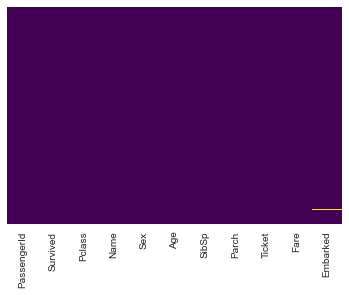

In [46]:
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'viridis');

Since its just like... 1 or 2 missing values at this point, I'll just fill them in with a T/F value

<AxesSubplot:xlabel='Embarked', ylabel='Count'>

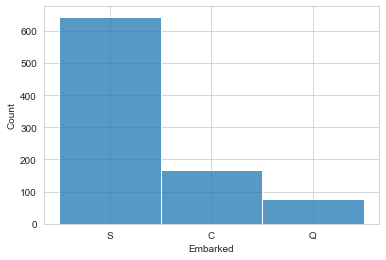

In [49]:
sns.histplot(train['Embarked'])

In [50]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

I'll just fill in the missing value in embarked with 'S' since it was the overwhelming majority of values

In [51]:
train['Embarked'].isnull().sum()

2

In [53]:
train.loc[train['Embarked'].isnull() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [62]:
type(train.loc[60]['Embarked'])

str

In [63]:
type(train.loc[61]['Embarked'])

float

In [64]:
train.loc[61]['Embarked'] = 'S';

In [66]:
train.loc[train['Embarked'].isnull() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


OK I will figure out how to insert the desired value into that column alter; will drop them both for now!

In [67]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [70]:
# Since it is pretty much guaranteed to be applied to the embark column
train.fillna('S', inplace = True);

In [71]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

I did it! I have no clue how IO forgot about the fillna method/function :|

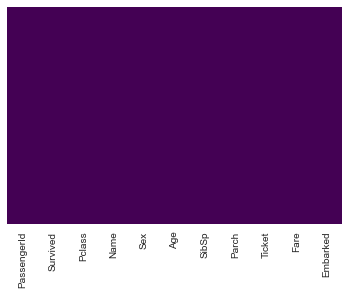

In [72]:
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'viridis');

#### Going to work on categorical features now
We do this by turning categorical features into dummy variables using pandas. If we don't do this (what seems to be one-hot-encoding), we won't be able to process this data via machine learning.

In [73]:
# similar to one-hot encoding????
pd.get_dummies(train['Sex'])

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


Since this will result in co-linearity, i.e. that one column data will be indicative of the other (as they are presupposed to be mutually exclusive in this case), we will drop one of the columns

In [77]:
isMale = pd.get_dummies(train['Sex'], drop_first = True)

In [78]:
isMale

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [80]:
isEmbark = pd.get_dummies(train['Embarked'], drop_first = True) # basically so that whatever is not Q or S can be clubbed under C

In [82]:
train = pd.concat([train, isMale, isEmbark], axis = 1);

In [83]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0


Now, the Embarked and sex columns are redundant. We will also not use Ticket or Name columns as there isn't a lot of relevant info in those columns for our purposes

In [84]:
train.drop(['Sex', 'Embarked', 'Name', 'Ticket'], axis = 1, inplace = True)

In [85]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


This is now perfect for our ML model

In [86]:
train.tail()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
886,887,0,2,27.0,0,0,13.00,1,0,1
887,888,1,1,19.0,0,0,30.00,0,0,1
888,889,0,3,24.0,1,2,23.45,0,0,1
889,890,1,1,26.0,0,0,30.00,1,0,0
890,891,0,3,32.0,0,0,7.75,1,1,0


In [87]:
# we can drop PassengerId to since it's pretty much just the index
train.drop(['PassengerId'], axis = 1, inplace = True);

In [88]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


NOTE: We can also encode the Pclass data as it is pretty much, like Embarked, divided into 3 groups. I'll get to that later as it might sabotage my learning with the model as of now (may result in needless complexity; something new data scientists are especially prone to)

I am now going to treat our training data as our entire data and the test data file as our testing sample to check the performance of our model

In [89]:
X = train.drop('Survived', axis = 1);
y = train['Survived'];

In [90]:
from sklearn.model_selection import train_test_split;

In [91]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=101);

In [92]:
from sklearn.linear_model import LogisticRegression;

In [93]:
model = LogisticRegression();

In [95]:
model.fit(X_train, y_train)

C:\Users\Shahbaz\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [98]:
y_pred_test = model.predict(X_test);

In [101]:
# To get values for out percission, recall vals, accuracy, F1 score, etc. 
from sklearn.metrics import classification_report;

In [103]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       154
           1       0.80      0.67      0.73       114

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.79      0.79      0.78       268



In [104]:
from sklearn.metrics import confusion_matrix;

In [105]:
confusion_matrix (y_test, y_pred_test)

array([[135,  19],
       [ 38,  76]], dtype=int64)